In [1]:
from pecanpy import pecanpy as pp
import utils
import networkx as nx
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import json
from numpy.typing import NDArray
from typing import Dict
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_classif
from training import train_gnn
from torch_geometric.data import Data
import torch
import torch_geometric as pyg

/home/cpittet/anaconda3/envs/ma4/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def init_result_folder(path: str) -> nx.Graph:
    if not os.path.exists(os.path.join(path, 'results')):
        os.mkdir(os.path.join(path, 'results'))

    with open(os.path.join(path, 'results', 'results.json'), 'w') as f:
        json.dump(dict(), f)

    path_split = path.split('/')
    city_name = path_split[-1]
    data_dir = os.path.join(*path_split[:-1])
    graph, _ = utils.create_city_graph(city_name, data_dir)
    graph = nx.DiGraph(graph)

    mapping = {k: i for i, k in enumerate(sorted(graph.nodes()))}
    graph = nx.relabel_nodes(graph, mapping)

    path_edg_file = os.path.join(path, 'adj_mat.edg')
    nx.write_edgelist(graph, path_edg_file, data=False, delimiter='\t')

    return graph


def save_embeddings(path: str, p: float, q: float, num_walks: int, dim: int = 256) -> NDArray[np.float_]:
    path_edg_file = os.path.join(path, 'adj_mat.edg')

    g = pp.SparseOTF(p=p, q=q, verbose=False, workers=16)
    g.read_edg(path_edg_file, weighted=False, directed=True)

    embeddings = g.embed(dim=dim, num_walks=num_walks)

    np.save(os.path.join(path, 'results', 'node2vec_embeddings.npy'), embeddings)

    return embeddings


def train_svm(features: NDArray[np.float_], targets: NDArray[np.float_], seed: int = 42,scale_features=False) -> Dict:
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=seed)

    model = SVC(class_weight='balanced', C=1)
    if scale_features:
        standard_scaler = StandardScaler()
        standard_scaler.fit(X_train)
        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        score = f_classif(X_train,y_train)
        #print(score[0])

    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    results = {}
    results['train'] = classification_report(y_train, train_preds, output_dict=True)
    results['test'] = classification_report(y_test, test_preds, output_dict=True)

    return results


def cities_loop(data_path: str, p: float, q: float, num_walks: int, dim: int) -> None:

    for entry in os.scandir(data_path):
        if entry.is_dir():
            city = entry.name
            graph = init_result_folder(entry.path)
            embeddings = save_embeddings(entry.path, p, q, num_walks=num_walks, dim=dim)
            
            targets = dict(graph.nodes(data='city_center'))
            targets = np.array([targets[v] for v in range(len(targets))])
            
            results = train_svm(embeddings, targets)
            df_features = pd.read_csv(os.path.join(data_path,"handcrafted_features.csv"))
            df_features = df_features[df_features["city"]==city]
            targets_handcrafted = df_features["city_center"].values
            features_handcrafted = df_features.drop(["stop_I","name","city_center","city","Unnamed: 0"],axis=1)

            results_handcrafted =  train_svm(features_handcrafted, targets_handcrafted,scale_features=True)

            with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
                res_dict = json.load(f)
            print()
            res_dict['baseline_svm'] = results
            res_dict["handcrafted_svm"] = results_handcrafted

            with open(os.path.join(entry.path, 'results', 'results.json'), 'w') as f:
                json.dump(res_dict, f)


def cities_loop_gnn(data_path: str, seed: int = 42) -> None:

    for entry in os.scandir(data_path):
        if entry.is_dir():
            city = entry.name
            print(city)
            
            df_features = pd.read_csv(os.path.join(data_path,"handcrafted_features.csv"))
            df_features = df_features[df_features["city"]==city]
            targets_handcrafted = df_features["city_center"].values
            features_handcrafted = df_features.drop(["stop_I", "name", "city_center", "city","Unnamed: 0"],axis=1).values
            graph = nx.read_edgelist(os.path.join(entry.path, 'adj_mat.edg'), create_using=nx.DiGraph)

            print(targets_handcrafted.shape)
            print(features_handcrafted.shape)
            
            print(f'number of edges in nx graph : {graph.number_of_edges()}')
            adj_mat = nx.adjacency_matrix(graph, weight=None) # not weighted
            print(f'adj mat shape : {adj_mat.shape}')
            edge_index, _ = pyg.utils.from_scipy_sparse_matrix(adj_mat)
            print(f'adj mat shape sparse tensor : {edge_index.shape}')

            d = Data(
                x=torch.from_numpy(features_handcrafted),
                y=torch.tensor(targets_handcrafted).clone(),
                edge_index=edge_index.clone(),
            )

            train_ids, test_ids = train_test_split(
                np.arange(features_handcrafted.shape[0]), test_size=0.2, stratify=targets_handcrafted, random_state=seed
            )

            train_ids, val_ids = train_test_split(
                train_ids, test_size=0.2, stratify=targets_handcrafted[train_ids], random_state=seed
            )

            pos_weight = np.sum(targets_handcrafted[train_ids] == 0) / np.sum(targets_handcrafted[train_ids] == 1)
            print(f'Pos weight : {pos_weight}')

            results_gnn = train_gnn(
                [d],
                train_ids,
                val_ids,
                test_ids,
                pos_weight=pos_weight,
                model_name='gnn',
                lr=1e-3,
                epochs=20,
                out_channels_graph=16,
                in_channels_graph=18,
                heads=5,
                dropout=0.0
            )
            results_gat = train_gnn(
                [d],
                train_ids,
                val_ids,
                test_ids,
                pos_weight=pos_weight,
                model_name='gat',
                lr=1e-3,
                epochs=20,
                out_channels_graph=16,
                in_channels_graph=18,
                heads=5,
                dropout=0.0
            )

            with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
                res_dict = json.load(f)
            print()
            res_dict['gnn'] = results_gnn
            res_dict["gat"] = results_gat

            with open(os.path.join(entry.path, 'results', 'results.json'), 'w') as f:
                json.dump(res_dict, f)

In [12]:
cities_loop_gnn('data')

bordeaux
(3414,)
(3414, 18)
number of edges in nx graph : 4039
adj mat shape : (3435, 3435)
adj mat shape sparse tensor : torch.Size([2, 4039])
Pos weight : 5.480712166172107


Epoch 1 / 20: 0it [00:00, ?it/s]


IndexError: Encountered an index error. Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 3413] (got interval [0, 3434])

In [9]:
cities_loop("data",p=5.0, q=0.1, num_walks=100,dim=256)

/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [7 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [8 9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7  8  9 10 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/envs/ma4/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [7]:

best_p = -1
best_q = -1
best_score = -1
attempts = []
for p in [0.1, 1.0, 5.0]:
    for q in [0.1, 0.5, 1.0, 2.0, 5.0]:
        f1_train = []
        f1_val = []
        for city in ["turku","detroit","paris","adelaide"]:
            print(f"starting training for {city} with p={p} and q={q}")
            city_name = city
            data_dir = 'data'
            graph, _ = utils.create_city_graph(city_name, data_dir)
            graph = nx.DiGraph(graph)

            mapping = {k: i for i, k in enumerate(sorted(graph.nodes()))}
            graph = nx.relabel_nodes(graph, mapping)

            path_edg_file = os.path.join(data_dir, city_name, 'adj_mat.edg')
            nx.write_edgelist(graph, path_edg_file, data=False, delimiter='\t')
            g = pp.SparseOTF(p=p, q=q, verbose=False, workers=16)
            g.read_edg(path_edg_file, weighted=False, directed=True)

            embeddings = g.embed(dim=256, num_walks=100)

            targets = dict(graph.nodes(data='city_center'))
            targets = np.array([targets[v] for v in range(len(targets))])
            X_train, X_test, y_train, y_test = train_test_split(embeddings, targets, test_size=0.2, stratify=targets,random_state=42)
            X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.15,stratify=y_train,random_state=42)
            model = SVC(class_weight='balanced', C=1)
            model.fit(X_train, y_train)

            train_preds = model.predict(X_train)
            train_rep = classification_report(y_train, train_preds,output_dict=True)
            val_preds = model.predict(X_val)
            val_rep = classification_report(y_val, val_preds,output_dict=True)

            f1_train.append(train_rep["1"]["f1-score"])
            f1_val.append(val_rep["1"]["f1-score"])
           
        avg_f1_train = np.mean(f1_train)
        avg_f1_val = np.mean(f1_val)
        attempts.append({"p":p,"q":q,"score_train":avg_f1_train,"score_val":avg_f1_val})

        if avg_f1_val  > best_score:
            best_score = avg_f1_val
            best_p = p
            best_q = q
print(f"best parameters with p={best_p} and q={best_q} and f1 {best_score}")


starting training for turku with p=0.1 and q=0.1
starting training for detroit with p=0.1 and q=0.1
starting training for paris with p=0.1 and q=0.1
starting training for adelaide with p=0.1 and q=0.1
starting training for turku with p=0.1 and q=0.5
starting training for detroit with p=0.1 and q=0.5
starting training for paris with p=0.1 and q=0.5
starting training for adelaide with p=0.1 and q=0.5
starting training for turku with p=0.1 and q=1.0
starting training for detroit with p=0.1 and q=1.0
starting training for paris with p=0.1 and q=1.0
starting training for adelaide with p=0.1 and q=1.0
starting training for turku with p=0.1 and q=2.0
starting training for detroit with p=0.1 and q=2.0
starting training for paris with p=0.1 and q=2.0
starting training for adelaide with p=0.1 and q=2.0
starting training for turku with p=0.1 and q=5.0
starting training for detroit with p=0.1 and q=5.0
starting training for paris with p=0.1 and q=5.0
starting training for adelaide with p=0.1 and q

In [8]:
import json
with open("save_p_q.json","w") as f:
    json.dump(attempts,f)

In [211]:
embeddings.shape

(1850, 256)

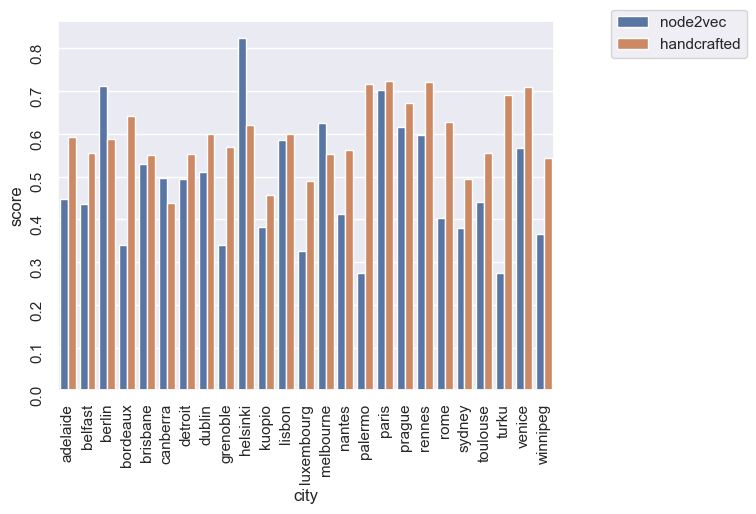

In [17]:
import seaborn as sns
lst = []
for entry in sorted(os.scandir("data"),key=lambda x: x.name):
    if entry.is_dir():
        city = entry.name
        with open(os.path.join(entry.path, 'results', 'results.json'), 'r') as f:
            res_dict = json.load(f)

        lst.append((city,"node2vec",res_dict["baseline_svm"]["test"]["1"]["f1-score"]))
        lst.append((city,"handcrafted",res_dict["handcrafted_svm"]["test"]["1"]["f1-score"]))
df = pd.DataFrame(lst,columns=["city","type","score"])
ax = sns.barplot(df, x="city",y="score",hue="type")
ax.tick_params(labelrotation=90) 
ax.legend(bbox_to_anchor=(1.1, 1.05),loc="upper left")

SVC(C=1, class_weight='balanced')

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1212
           1       0.49      0.90      0.63       268

    accuracy                           0.81      1480
   macro avg       0.73      0.85      0.75      1480
weighted avg       0.88      0.81      0.83      1480



              precision    recall  f1-score   support

           0       0.82      0.67      0.74       303
           1       0.18      0.33      0.23        67

    accuracy                           0.61       370
   macro avg       0.50      0.50      0.49       370
weighted avg       0.70      0.61      0.65       370

